# Проект: "Поиск по изображениям"

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. 

## Цель:

Разработка поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.

Для демонстрационной версии нужно выбрать лучшую модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 

## Юридические ограничения

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

### Описание данных

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

<div class="alert alert-block alert-info">
<b>Просьба: </b> Для меня данный проект оказался самым тяжёлым на всем курсе обучения. Потратил очень много времени и сил на его выполнение, но так и не получилось сделать до конца. Прошу помочь с обучением нейронной сети. Я зашел в тупик и не знаю что с ней не так и почему она так плохо обучается и предсказывает оценки.
</div>

In [1]:
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
pd.set_option('display.float_format', '{:,.2f}'.format) # убираем экспонентациальные формы
import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)

from os.path import exists, isfile, join
import matplotlib.pyplot as plt
from PIL import Image
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from nltk.corpus import stopwords
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

Для получения повторяемых результатов, зафиксируем состояния герераторов случайных чисел

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Загрузка и исследовательский анализ данных

In [3]:
if exists("D:/1pr/to_upload"):
    data_path = "D:/1pr/to_upload"
else:
    data_path = "/datasets/image_search"

In [4]:
train_path = join(data_path, "train_images")
test_path = join(data_path, "test_images")

In [5]:
train_dataset = pd.read_csv(join(data_path, "train_dataset.csv"))

In [6]:
train_dataset

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


In [7]:
train_dataset.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Выводим изображения

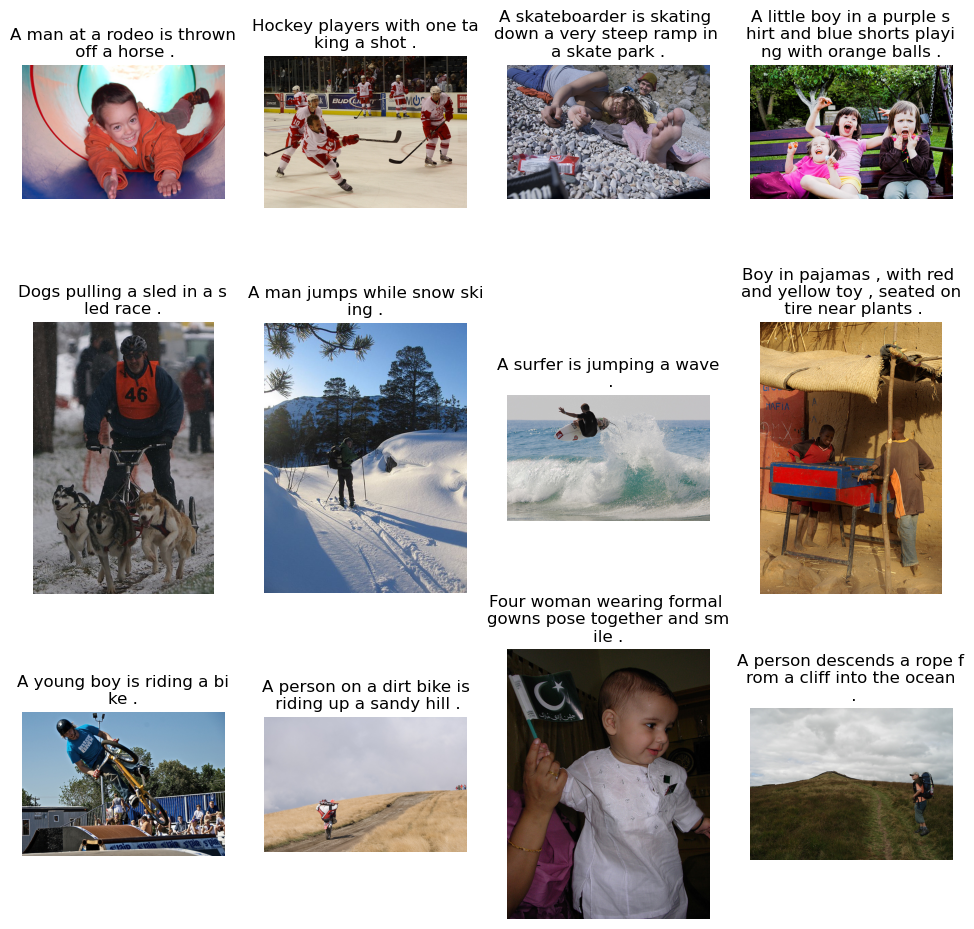

In [8]:
count = 1
fig = plt.figure(figsize=(12, 12))
for _, file, query_text in train_dataset[['image','query_text']].sample(12).itertuples():
    img = Image.open(join(train_path, file))
    fig.add_subplot(3, 4, count)
    count += 1
    plt.imshow(np.array(img))
    plt.axis("off")
    chunks, chunk_size = len(query_text), 26
    plt.title("\n".join([query_text[i : i + chunk_size] for i in range(0, chunks, chunk_size)]));

переименовываем столбец

In [9]:
train_dataset = train_dataset.rename(columns={"query_id": "annotation_id"})

Загружаем экспертные оценки

In [10]:
expert_annotations = pd.read_csv(
    join(data_path, "ExpertAnnotations.tsv"), sep="\t", header=None)

In [11]:
expert_annotations.columns = ["image", "annotation_id", "score_1", "score_2", "score_3"]

In [12]:
expert_annotations

,image,annotation_id,score_1,score_2,score_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1


In [13]:
expert_annotations.describe()

,score_1,score_2,score_3
count,"5,822.00","5,822.00","5,822.00"
mean,1.44,1.62,1.88
std,0.79,0.86,0.90
min,1.00,1.00,1.00
25%,1.00,1.00,1.00
50%,1.00,1.00,2.00
75%,2.00,2.00,2.00
max,4.00,4.00,4.00


Загружаем данные краудсорсинга

In [14]:
crowd_annotations = pd.read_csv(
    join(data_path, "CrowdAnnotations.tsv"), sep="\t", header=None)

In [15]:
crowd_annotations.columns = ["image", "annotation_id", "ratio", "positive", "negative"]

In [16]:
crowd_annotations

,image,annotation_id,ratio,positive,negative
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.00,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.00,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.00,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.00,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.00,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.00,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.33,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.00,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.00,0,3


объединяем мнения экспертов и доли соответствия текста изображению.

In [17]:
expert_annotations = expert_annotations.merge(
    crowd_annotations[["image", "annotation_id", "ratio"]],
    on=["image", "annotation_id"], how="left")

In [18]:
expert_annotations['ratio'] = expert_annotations['ratio'].fillna(0)

In [19]:
expert_annotations

,image,annotation_id,score_1,score_2,score_3,ratio
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.00
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.00
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.00
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.00
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.00
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,0.00
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,0.00
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,0.00
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,0.00


Загружаем тестовые данные

In [20]:
test_queries = pd.read_csv(join(data_path, "test_queries.csv"), sep="|", index_col=0)

In [21]:
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [22]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


In [23]:
test_images = pd.read_csv(join(data_path, "test_images.csv"))

In [24]:
test_images.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [25]:
test_images.describe()

,image
count,100
unique,100
top,3356748019_2251399314.jpg
freq,1


### Вывод

1. Загрузили данные на которых планируем обучать модели.
2. Загрнузили тестовые данные.
3. Подготовили данные для определения рейтинга соответствия картинки и текста.

## Подготовка данных


### Построение сводной экспертной оценки

In [26]:
def comparison(a1, a2, a3, b1):
    """функция принимает оценки экспертов и долю соответсвия и возвращает рейтинг соответствия"""
    if a1 == a2:
        return round(a1*0.1+a3*0.05+b1*0.4, 2)
    elif a1 == a3:
        return round(a1*0.1+a2*0.05+b1*0.4, 2)
    elif a2 == a3:
        return round(a2*0.1+a1*0.05+b1*0.4, 2)
    else:
        return 0

In [27]:
expert_annotations["experts"] = expert_annotations.apply(    
    lambda x: comparison(x["score_1"], x["score_2"], x["score_3"], x["ratio"] ), axis=1)

Сохраняем только рейтинг соответствия только который больше 0,1

In [28]:
data_expert_annotations = expert_annotations[['image', 'annotation_id','experts']][expert_annotations['experts'] > 0.1].copy()

Смотрим уникальные значения полученных рейтингов.

In [29]:
data_expert_annotations['experts'].unique()

array([0.15, 0.2 , 0.25, 0.3 , 0.53, 0.35, 0.4 , 0.48, 0.45, 0.87, 0.95,
       1.  , 0.85, 0.62, 0.43, 0.5 , 0.9 , 0.72, 0.33, 0.38, 0.67, 0.58,
       0.63, 0.77, 0.73, 0.55, 0.68, 0.82, 0.7 , 0.8 , 0.6 , 0.61, 0.57,
       0.52, 0.65, 0.75, 0.28])

In [30]:
data_expert_annotations

,image,annotation_id,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.15
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.20
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.20
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.25
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.20
...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.15
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.15
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.20
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.15


Проставляем рейтинги для тренировочных данных

In [31]:
df = (
    train_dataset.set_index(["image", "annotation_id"])
    .join(
        data_expert_annotations.set_index(["image", "annotation_id"])[["experts"]],
        how="inner",
    )
    .reset_index()
).copy()

In [32]:
df

,image,annotation_id,query_text,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.00
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15
...,...,...,...,...
5691,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,0.48
5692,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0.15
5693,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0.30
5694,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.40


### Лемматизация описаний

In [33]:
#spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])

In [34]:
def lemmatizered(corpus):
    ''' функция выполняет токенизациию и лемматизацию массива текстов'''
    corpus_new = []
    for sentence in corpus:
        sentence = sentence.replace('  ', ' ')
        doc = nlp(sentence)      
        corpus_new.append(" ".join([token.lemma_ for token in doc]))
    return corpus_new

In [35]:
%%time
pattern = r'[^a-zA-Z0-9]'
df['clear_text'] = df['query_text'].apply(lambda x: re.sub(pattern, " ", x))
df['clear_text'] = lemmatizered(df['clear_text'])
df.head()

Wall time: 8.18 s


,image,annotation_id,query_text,experts,clear_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15,a young child be wear blue goggle and sit in a...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15,a young child be wear blue goggle and sit in a...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,a young child be wear blue goggle and sit in a...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.00,a young child be wear blue goggle and sit in a...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15,a young child be wear blue goggle and sit in a...


### Разбиение тренировочного множества на тренировочную и валидационную выборки

In [36]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=42)
train_indices, valid_indices = next(
    gss.split(
        X=df.drop(columns=["annotation_id"]),
        y=df["annotation_id"],
        groups=df["image"],
    )
)
train_df, valid_df = df.iloc[train_indices], df.iloc[valid_indices]

In [37]:
train_df.head()

,image,annotation_id,query_text,experts,clear_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15,a young child be wear blue goggle and sit in a...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15,a young child be wear blue goggle and sit in a...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,a young child be wear blue goggle and sit in a...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.00,a young child be wear blue goggle and sit in a...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15,a young child be wear blue goggle and sit in a...


In [38]:
valid_df.head()

,image,annotation_id,query_text,experts,clear_text
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.35,a young child be wear blue goggle and sit in a...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15,a young child be wear blue goggle and sit in a...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15,a young child be wear blue goggle and sit in a...
11,486712504_36be449055.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.15,a young child be wear blue goggle and sit in a...
14,2616643090_4f2d2d1a44.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.15,a girl wear a yellow shirt and sunglass smile


### Векторизация описаний

In [39]:
#import nltk
#nltk.download()

In [40]:
stop_words = set(stopwords.words("english"))

In [41]:
tfvect = TfidfVectorizer(stop_words=stop_words)

Векторизируем текст

In [42]:
train_tf_text = tfvect.fit_transform(train_df["clear_text"])
valid_tf_text = tfvect.transform(valid_df["clear_text"])

In [43]:
train_tf_text = train_tf_text.toarray()
train_tf_text.shape

(4279, 1153)

In [44]:
valid_tf_text = valid_tf_text.toarray()
valid_tf_text.shape

(1417, 1153)

### Векторизация изображений

Загрузим модель ResNet-18:

In [45]:
resnet = models.resnet18(pretrained=True) #загружаем претренированную модель 

Нам не потребуется обучать модель, поэтому рекомендуем заморозить веса:

In [46]:
for param in resnet.parameters():
    param.requires_grad_(False) 

После заморозки весов надо определиться, все ли слои можно использовать для получения эмбеддингов. На практике используются только свёрточные слои. Для получения списка слоёв пригодится метод children():

In [47]:
print(list(resnet.children())) 

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

В нашем случае, нужно взять все слои, кроме последних двух:

In [48]:
modules = list(resnet.children())[:-1]

In [49]:
resnet = nn.Sequential(*modules) 

Не забудем перевести модель в режим предсказания:

In [50]:
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Теперь перейдём к тому, как получить предсказания. Для начала изображение нужно привести в нужный формат. Для изменяют размер картинки, вырезают центр и нормализуют:

In [51]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

Данные преобразования применимы к модели ResNet. Для других моделей уточняйте необходимые преобразования в документации.
Для чтения изображений понадобится библиотека PIL:

In [52]:
%%time
train_img = train_df.apply(
    lambda x: resnet(
        preprocess(
            Image.open(
                join(train_path, x["image"])).convert('RGB')).unsqueeze(0)).flatten(), axis=1)

Wall time: 1min 36s


In [53]:
%%time
valid_img = valid_df.apply(
    lambda x: resnet(
        preprocess(
            Image.open(
                join(train_path, x["image"])).convert('RGB')).unsqueeze(0)).flatten(), axis=1)

Wall time: 32.6 s


In [54]:
%%time
test_img = test_images.apply(
    lambda x: resnet(
        preprocess(
            Image.open(
                join(test_path, x["image"])).convert('RGB')).unsqueeze(0)).flatten(), axis=1)

Wall time: 2.23 s


In [55]:
image_vecs = []
for tensor in train_img.to_numpy():
    image_vecs.append(list(tensor.numpy()))
train_tf_img = np.array(image_vecs)
train_tf_img.shape

(4279, 512)

In [56]:
image_vecs = []
for tensor in valid_img.to_numpy():
    image_vecs.append(list(tensor.numpy()))
valid_tf_img = np.array(image_vecs)
valid_tf_img.shape

(1417, 512)

In [57]:
image_vecs = []
for tensor in test_img.to_numpy():
    image_vecs.append(list(tensor.numpy()))
test_tf_img = np.array(image_vecs)
test_tf_img.shape

(100, 512)

Тогда получение эмбеддинга для конкретной картинки будет выглядеть так:

In [58]:
df_train = np.concatenate((train_tf_img, train_tf_text), axis=1)
df_train.shape

(4279, 1665)

In [59]:
df_valid = np.concatenate((valid_tf_img, valid_tf_text), axis=1)
df_valid.shape

(1417, 1665)

## Обучение моделей

Готовим данные для обучения

In [60]:
X_train = df_train.copy() 
Y_train = train_df['experts'].reset_index(drop=True)

In [61]:
X_valid = df_valid.copy() 
Y_valid = valid_df['experts'].reset_index(drop=True)

### Линейная регрессия

In [62]:
model = LinearRegression().fit(X_train, Y_train)

In [63]:
predicted_valid = model.predict(X_valid)

In [64]:
mean_squared_error(Y_valid, predicted_valid)

0.06720294801018126

Качество обученной модели линейной регрессии на валидационной выборке составила 0,067

### Нейронная сеть

In [65]:
vector_size = X_train.shape[1]
vector_size

1665

In [66]:
def create_nn_model():
    optimizer = Adam()
    model = Sequential()    
    model.add(Dense(64, activation="relu", input_dim=vector_size))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="relu"))
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=["mse"])

    return model

In [67]:
nn_model = create_nn_model()

In [68]:
history = nn_model.fit(
    tf.cast(X_train, dtype=np.float32),
    tf.cast(Y_train, dtype=np.float32),
    batch_size=16,
    epochs=20,
    validation_data=(X_valid, Y_valid),
)

Epoch 1/20
268/268 [==============================] - 1s 1ms/step - loss: 0.1244 - mse: 0.1244 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 2/20
268/268 [==============================] - 0s 1ms/step - loss: 0.1197 - mse: 0.1197 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 3/20
268/268 [==============================] - 0s 1ms/step - loss: 0.1195 - mse: 0.1195 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 4/20
268/268 [==============================] - 0s 1ms/step - loss: 0.1196 - mse: 0.1196 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 5/20
268/268 [==============================] - 0s 1ms/step - loss: 0.1197 - mse: 0.1197 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 6/20
268/268 [==============================] - 0s 1ms/step - loss: 0.1198 - mse: 0.1198 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 7/20
268/268 [==============================] - 0s 1ms/step - loss: 0.1197 - mse: 0.1197 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 8/20
268/268 [==============================] - 0s 1ms/step - loss: 0.

Качество обученной модели нейросети на валидационной выборке составила 0,1141

## Тестирование модели

In [69]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
indexes = np.random.randint(0, 499, size=1)
queries = test_queries.loc[indexes, 'query_text'].values

In [70]:
def image_search(text, test_img, model, test_images):
    '''Принимает на вход текстовое описание, делает его векторизацию
    и возвращает картинку с максимальным значением метрики'''
    text_lem = []
    for x in range(len(queries)):
        text_lem.append(re.sub(pattern, " ", queries[x]))
    text_lem = np.array(text_lem, dtype=object)
    text_lem = lemmatizered(text_lem)
    text_test_vec = tfvect.transform(text_lem)
    text_test_vec = text_test_vec.toarray()
    
    for n in range(7):
        text_test_vec = np.concatenate((text_test_vec, text_test_vec))
    text_test_vec = text_test_vec[0:100]
    X = np.concatenate((test_img, text_test_vec), axis=1)
    X = torch.FloatTensor(X)
    X = X.to(DEVICE)
    X = tf.cast(X, dtype=np.float32)
    preds_val = model.predict(X).flatten()
    idx = np.argsort(preds_val)[-3:]
    name = test_images.loc[idx, 'image']
    return name

Тестируем модель линейной регрессии

A young boy throwing a rock into a pond in front of a large building .


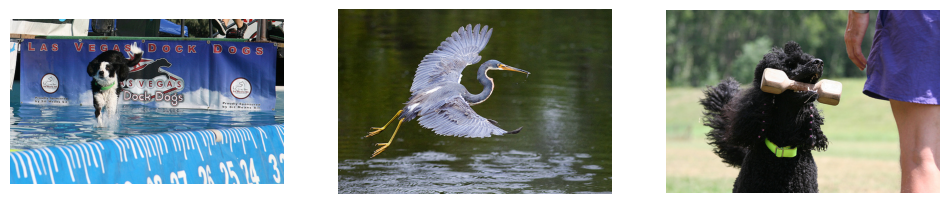

In [71]:
count = 1
print(queries[0])
fig = plt.figure(figsize=(12, 12))
for x in image_search(queries, test_tf_img, model, test_images):    
    img = Image.open(join(test_path, x))
    fig.add_subplot(1, 3, count)
    count += 1
    plt.imshow(np.array(img))
    plt.axis("off")

Тестируем модель нейросети

A young boy throwing a rock into a pond in front of a large building .
4/4 [==============================] - 0s 1ms/step


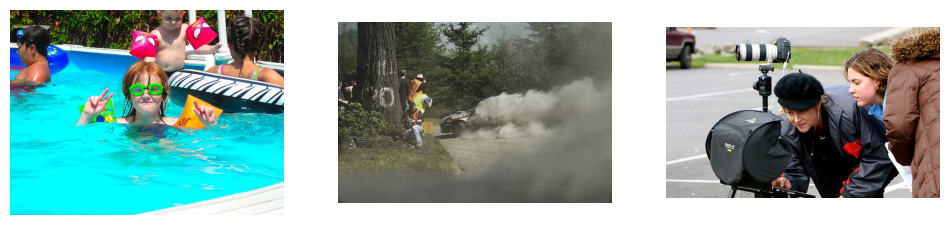

In [72]:
count = 1
print(queries[0])
fig = plt.figure(figsize=(12, 12))
for x in image_search(queries, test_tf_img, nn_model, test_images):    
    img = Image.open(join(test_path, x))
    fig.add_subplot(1, 3, count)
    count += 1
    plt.imshow(np.array(img))
    plt.axis("off")

### Выводы

Модель линейной регрессии показала лучшее качество чем нейросеть.